## Classifying Twitter Dataset

In [1]:
import pandas as pd
data = pd.read_csv("data_folder/tweet_dataset.csv")
tweet_list = []
label_list = []
for each in list(data.iloc[:,2]):
    tweet_list.append(each.split())
for each in list(data.iloc[:,1]):
    label_list.append(each.split())
dataset_len = len(tweet_list)
train_tweet_list = tweet_list[:dataset_len*6//10]
test_tweet_list = tweet_list[dataset_len*6//10:]
train_label_list = label_list[:dataset_len*6//10]
test_label_list = label_list[dataset_len*6//10:]
#print(tweet_list)
#print(set(data.iloc[:,1]))

In [2]:
'''
Self Model with word vector size 100
'''
from gensim.models import Word2Vec
model = Word2Vec(train_tweet_list,min_count = 1,sg=1)
print(model)
vocab = model.wv.vocab
vocab_vector = model[vocab]
model.save('model100')

C:\Users\HP\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Word2Vec(vocab=15377, size=100, alpha=0.025)


C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


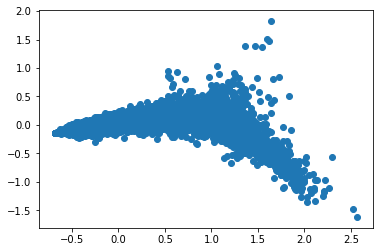

In [3]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components = 2)
vector = pca.fit_transform(vocab_vector)
plt.scatter(vector[:,0],vector[:,1])
plt.show()


In [4]:
model = Word2Vec.load("model100")
vocab = model.wv.vocab
print(test_tweet_list[160])
model.most_similar('did')[0][1]

['PAX', 'ugh', 'what', 'did', 'they', 'do', 'this', 'year']


C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.
C:\Users\HP\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.9707221984863281

# Classification using Neural network
## we are using MLPClassifier algorithm

By taking the word vector of sentences as the average of word vector of word present in sentence as well as Word2Vec vocablury

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import numpy as np
X = []

for each in train_tweet_list:
    t = np.zeros(100)
    for i in each[1:]:
        t = t + model[i]
    t = t / len(each)
    X.append(t)
clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(100,),warm_start=True, random_state=1)
clf.fit(X,train_label_list)
'''
converting test tweet dataset to word vectors
'''
test_vector = []
for each in test_tweet_list:
    t = np.zeros(100)
    for i in each[1:]:
        if i in vocab:
            t = t + model[i]          # after excluding below else statement accuracy in self word vector is 0.7217149048134963
        '''
        else: 
            t = t + np.zeros(100)     # after including this else statement our accuracy is 0.7209410308001857
        '''
        '''
            from gensim.models import FastText as ftext
            fast_text_wv = ftext(train_tweet_list)                  this code cand be used for words not in vocab
            word = (fast_text_wv.most_similar(i))[0][0]             some words are still giving some error
            t = t + model[word]
        '''
            
    t = t / len(each)
    test_vector.append(t)
pred = clf.predict(test_vector)
acc = accuracy_score(test_label_list,pred)
print(acc)


C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


0.7720167156786875


By taking the word vector of sentences as the average of weighted word vector of word present in sentence as well as Word2Vec vocablury. weighted word vector can be found by multiplying word vector to its Tf-idf score.


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(['tweet_dataset.csv'],stop_words=None,analyzer='word')

vectorizer1 = TfidfVectorizer(['tweet_dataset.csv'],stop_words=None,analyzer='char')
vec = vectorizer.fit_transform(data.iloc[:,2])
vec1 = vectorizer1.fit_transform(data.iloc[:,2])
v = dict(zip(vectorizer.get_feature_names(),vectorizer.idf_))
v1 = dict(zip(vectorizer1.get_feature_names(),vectorizer1.idf_))



In [7]:
X_tf = []
for each in train_tweet_list:
    t = np.zeros(100)
    for i in each[1:]:
        if len(i)==1:
            t = t + model[i] * v1[i.lower()]
        else:
            t = t + model[i] * v[i.lower()]
    t = t / len(each)
    X_tf.append(t)
clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(100,), random_state=1)
clf.fit(X_tf,train_label_list)
'''
converting test tweet dataset to word vectors
'''
test_vector_tf = []
for each in test_tweet_list:
    t = np.zeros(100)
    for i in each[1:]:
        if i in vocab:
            if len(i)==1:
                t = t + model[i] * v1[i.lower()]
            else:
                t = t + model[i] * v[i.lower()]
            
    t = t / len(each)
    test_vector_tf.append(t)
pred = clf.predict(test_vector_tf)
acc = accuracy_score(test_label_list,pred)
print(acc)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4

0.7611824794923386


In [8]:
'''
Self Model with word vector size 200
'''
model = Word2Vec(train_tweet_list,size = 200,min_count = 1,sg=1)
print(model)
vocab = model.wv.vocab
vocab_vector = model[vocab]
model.save('model200')

Word2Vec(vocab=15377, size=200, alpha=0.025)


C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [9]:
X = []

for each in train_tweet_list:
    t = np.zeros(200)
    for i in each[1:]:
        t = t + model[i]
    t = t / len(each)
    X.append(t)
clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(100,),warm_start=True, random_state=1)
clf.fit(X,train_label_list)
'''
converting test tweet dataset to word vectors
'''
test_vector = []
for each in test_tweet_list:
    t = np.zeros(200)
    for i in each[1:]:
        if i in vocab:
            t = t + model[i]          # after excluding below else statement accuracy in self word vector is 0.7217149048134963
            
    t = t / len(each)
    test_vector.append(t)
pred = clf.predict(test_vector)
acc = accuracy_score(test_label_list,pred)
print(acc)


C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


0.7707785172573905


In [10]:
X_tf = []
for each in train_tweet_list:
    t = np.zeros(200)
    for i in each[1:]:
        if len(i)==1:
            t = t + model[i] * v1[i.lower()]
        else:
            t = t + model[i] * v[i.lower()]
    t = t / len(each)
    X_tf.append(t)
clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(100,), random_state=1)
clf.fit(X_tf,train_label_list)
'''
converting test tweet dataset to word vectors
'''
test_vector_tf = []
for each in test_tweet_list:
    t = np.zeros(200)
    for i in each[1:]:
        if i in vocab:
            if len(i)==1:
                t = t + model[i] * v1[i.lower()]
            else:
                t = t + model[i] * v[i.lower()]        
       
    t = t / len(each)
    test_vector_tf.append(t)
pred = clf.predict(test_vector_tf)
acc = accuracy_score(test_label_list,pred)
print(acc)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4

0.7684568952174586


In [11]:
'''
Self Model with word vector size 300
'''
from gensim.models import Word2Vec
model = Word2Vec(train_tweet_list,size = 300,min_count = 1,sg=1)
print(model)
vocab = model.wv.vocab
vocab_vector = model[vocab]
model.save('model300')

Word2Vec(vocab=15377, size=300, alpha=0.025)


C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [12]:
X = []

for each in train_tweet_list:
    t = np.zeros(300)
    for i in each[1:]:
        t = t + model[i]
    t = t / len(each)
    X.append(t)
clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(100,),warm_start=True, random_state=1)
clf.fit(X,train_label_list)
'''
converting test tweet dataset to word vectors
'''
test_vector = []
for each in test_tweet_list:
    t = np.zeros(300)
    for i in each[1:]:
        if i in vocab:
            t = t + model[i]                  
            
    t = t / len(each)
    test_vector.append(t)
pred = clf.predict(test_vector)
acc = accuracy_score(test_label_list,pred)
print(acc)


C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


0.7709332920600527


In [13]:
X_tf = []
for each in train_tweet_list:
    t = np.zeros(300)
    for i in each[1:]:
        if len(i)==1:
            t = t + model[i] * v1[i.lower()]
        else:
            t = t + model[i] * v[i.lower()]
    t = t / len(each)
    X_tf.append(t)
clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(100,), random_state=1)
clf.fit(X_tf,train_label_list)
'''
converting test tweet dataset to word vectors
'''
test_vector_tf = []
for each in test_tweet_list:
    t = np.zeros(300)
    for i in each[1:]:
        if i in vocab:
            if len(i)==1:
                t = t + model[i] * v1[i.lower()]
            else:
                t = t + model[i] * v[i.lower()]        
            
    t = t / len(each)
    test_vector_tf.append(t)
pred = clf.predict(test_vector_tf)
acc = accuracy_score(test_label_list,pred)
print(acc)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4

0.7704689676520663


# the accuracy of Neural Network by using Tfidf Vectorizer is 0.6935458907289893

# Classification using Google word vector

In [14]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin",binary=True)

In [15]:
X = []

for each in train_tweet_list:
    t = np.zeros(300)
    for i in each[1:]:
        if i in model.wv.vocab:
            t = t + model[i]
    t = t / len(each)
    X.append(t)
#X = np.asarray(X)
#print(len(train_label_list))
clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(100,),warm_start=True, random_state=1)
clf.fit(X,train_label_list)
'''
converting test tweet dataset to word vectors
'''
test_vector = []
for each in test_tweet_list:
    t = np.zeros(300)
    for i in each[1:]:
        if i in model.wv.vocab:
            t = t + model[i]          
    t = t / len(each)
    test_vector.append(t)
pred = clf.predict(test_vector)
print(pred)
acc = accuracy_score(test_label_list,pred)
print(acc)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


['none' 'none' 'none' ... 'sexism' 'sexism' 'none']
0.7902801423928184


In [16]:
X_tf = []
for each in train_tweet_list:
    t = np.zeros(300)
    for i in each[1:]:
        if i in model.wv.vocab:
            if len(i)==1:
                t = t + model[i] * v1[i.lower()]
            else:
                t = t + model[i] * v[i.lower()]
    t = t / len(each)
    X_tf.append(t)
clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(100,), random_state=1)
clf.fit(X_tf,train_label_list)
'''
converting test tweet dataset to word vectors
'''
test_vector_tf = []
for each in test_tweet_list:
    t = np.zeros(300)
    for i in each[1:]:
        if i in model.wv.vocab:
            if len(i)==1:
                t = t + model[i] * v1[i.lower()]
            else:
                t = t + model[i] * v[i.lower()]           
       
            
    t = t / len(each)
    test_vector_tf.append(t)
pred = clf.predict(test_vector_tf)
acc = accuracy_score(test_label_list,pred)
print(acc)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


0.7853273487076304


# Classification Using Stanford word vector

In [17]:
'''
Model with word vector dimension 300
'''

from gensim.scripts.glove2word2vec import glove2word2vec
glove2word2vec("glove.6B.300d.txt","glove.300d.txt")
model = KeyedVectors.load_word2vec_format("glove.300d.txt",binary=False)

In [18]:
X = []

for each in train_tweet_list:
    t = np.zeros(300)
    for i in each[1:]:
        if i in model.wv.vocab:
            t = t + model[i]
    t = t / len(each)
    X.append(t)
clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(100,),warm_start=True, random_state=1)
clf.fit(X,train_label_list)
'''
converting test tweet dataset to word vectors
'''
test_vector = []
for each in test_tweet_list:
    t = np.zeros(300)
    for i in each[1:]:
        if i in model.wv.vocab:
            t = t + model[i]          
        
            
    t = t / len(each)
    test_vector.append(t)
pred = clf.predict(test_vector)
print(pred)
acc = accuracy_score(test_label_list,pred)
print(acc)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


['none' 'none' 'none' ... 'sexism' 'sexism' 'none']
0.7449311252128153


In [19]:
X_tf = []
for each in train_tweet_list:
    t = np.zeros(300)
    for i in each[1:]:
        if i in model.wv.vocab:
            if len(i)==1:
                t = t + model[i] * v1[i.lower()]
            else:
                t = t + model[i] * v[i.lower()]
    t = t / len(each)
    X_tf.append(t)
clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(100,), random_state=1)
clf.fit(X_tf,train_label_list)
'''
converting test tweet dataset to word vectors
'''
test_vector_tf = []
for each in test_tweet_list:
    t = np.zeros(300)
    for i in each[1:]:
        if i in model.wv.vocab:
            if len(i)==1:
                t = t + model[i] * v1[i.lower()]
            else:
                t = t + model[i] * v[i.lower()]           
       
            
    t = t / len(each)
    test_vector_tf.append(t)
pred = clf.predict(test_vector_tf)
acc = accuracy_score(test_label_list,pred)
print(acc)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


0.7320848165918589


In [20]:
'''
Model with word vector dimension 200
'''

glove2word2vec("glove.6B.200d.txt","glove.200d.txt")
model = KeyedVectors.load_word2vec_format("glove.200d.txt",binary=False)

In [21]:
X = []

for each in train_tweet_list:
    t = np.zeros(200)
    for i in each[1:]:
        if i in model.wv.vocab:
            t = t + model[i]
    t = t / len(each)
    X.append(t)
#X = np.asarray(X)
#print(len(train_label_list))
clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(100,),warm_start=True, random_state=1)
clf.fit(X,train_label_list)
'''
converting test tweet dataset to word vectors
'''
test_vector = []
for each in test_tweet_list:
    t = np.zeros(200)
    for i in each[1:]:
        if i in model.wv.vocab:
            t = t + model[i]          
        
            
    t = t / len(each)
    test_vector.append(t)
pred = clf.predict(test_vector)
print(pred)
acc = accuracy_score(test_label_list,pred)
print(acc)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


['none' 'none' 'none' ... 'sexism' 'sexism' 'none']
0.7422999535675592


In [22]:
X_tf = []
for each in train_tweet_list:
    t = np.zeros(200)
    for i in each[1:]:
        if i in model.wv.vocab:
            if len(i)==1:
                t = t + model[i] * v1[i.lower()]
            else:
                t = t + model[i] * v[i.lower()]
    t = t / len(each)
    X_tf.append(t)
clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(100,), random_state=1)
clf.fit(X_tf,train_label_list)
'''
converting test tweet dataset to word vectors
'''
test_vector_tf = []
for each in test_tweet_list:
    t = np.zeros(200)
    for i in each[1:]:
        if i in model.wv.vocab:
            if len(i)==1:
                t = t + model[i] * v1[i.lower()]
            else:
                t = t + model[i] * v[i.lower()]           
       
            
    t = t / len(each)
    test_vector_tf.append(t)
pred = clf.predict(test_vector_tf)
acc = accuracy_score(test_label_list,pred)
print(acc)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


0.7282154465253057


In [23]:
'''
Model with word vector dimension 100
'''

glove2word2vec("glove.6B.100d.txt","glove.100d.txt")
model = KeyedVectors.load_word2vec_format("glove.100d.txt",binary=False)

In [24]:
X = []

for each in train_tweet_list:
    t = np.zeros(100)
    for i in each[1:]:
        if i in model.wv.vocab:
            t = t + model[i]
    t = t / len(each)
    X.append(t)
clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(100,),warm_start=True, random_state=1)
clf.fit(X,train_label_list)
'''
converting test tweet dataset to word vectors
'''
test_vector = []
for each in test_tweet_list:
    t = np.zeros(100)
    for i in each[1:]:
        if i in model.wv.vocab:
            t = t + model[i]          
        
            
    t = t / len(each)
    test_vector.append(t)
pred = clf.predict(test_vector)
print(pred)
acc = accuracy_score(test_label_list,pred)
print(acc)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


['none' 'none' 'none' ... 'sexism' 'sexism' 'none']
0.7576226590311097


In [25]:
X_tf = []
for each in train_tweet_list:
    t = np.zeros(100)
    for i in each[1:]:
        if i in model.wv.vocab:
            if len(i)==1:
                t = t + model[i] * v1[i.lower()]
            else:
                t = t + model[i] * v[i.lower()]
    t = t / len(each)
    X_tf.append(t)
clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(100,), random_state=1)
clf.fit(X_tf,train_label_list)
'''
converting test tweet dataset to word vectors
'''
test_vector_tf = []
for each in test_tweet_list:
    t = np.zeros(100)
    for i in each[1:]:
        if i in model.wv.vocab:
            if len(i)==1:
                t = t + model[i] * v1[i.lower()]
            else:
                t = t + model[i] * v[i.lower()]           
       
            
    t = t / len(each)
    test_vector_tf.append(t)
pred = clf.predict(test_vector_tf)
acc = accuracy_score(test_label_list,pred)
print(acc)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


0.7138213898777279


In [26]:
'''
Model with word vector dimension 50
'''
glove2word2vec("glove.6B.50d.txt","glove.50d.txt")
model = KeyedVectors.load_word2vec_format("glove.50d.txt",binary=False)

In [27]:
X = []

for each in train_tweet_list:
    t = np.zeros(50)
    for i in each[1:]:
        if i in model.wv.vocab:
            t = t + model[i]
    t = t / len(each)
    X.append(t)
clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(100,),warm_start=True, random_state=1)
clf.fit(X,train_label_list)
'''
converting test tweet dataset to word vectors
'''
test_vector = []
for each in test_tweet_list:
    t = np.zeros(50)
    for i in each[1:]:
        if i in model.wv.vocab:
            t = t + model[i]          
        
            
    t = t / len(each)
    test_vector.append(t)
pred = clf.predict(test_vector)
print(pred)
acc = accuracy_score(test_label_list,pred)
print(acc)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


['none' 'none' 'none' ... 'sexism' 'sexism' 'none']
0.7585513078470825


In [28]:
X_tf = []
for each in train_tweet_list:
    t = np.zeros(50)
    for i in each[1:]:
        if i in model.wv.vocab:
            if len(i)==1:
                t = t + model[i] * v1[i.lower()]
            else:
                t = t + model[i] * v[i.lower()]
    t = t / len(each)
    X_tf.append(t)
clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(100,), random_state=1)
clf.fit(X_tf,train_label_list)
'''
converting test tweet dataset to word vectors
'''
test_vector_tf = []
for each in test_tweet_list:
    t = np.zeros(50)
    for i in each[1:]:
        if i in model.wv.vocab:
            if len(i)==1:
                t = t + model[i] * v1[i.lower()]
            else:
                t = t + model[i] * v[i.lower()]           
       
            
    t = t / len(each)
    test_vector_tf.append(t)
pred = clf.predict(test_vector_tf)
acc = accuracy_score(test_label_list,pred)
print(acc)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


0.7272867977093329
